In [1]:
# !pip install folium

In [3]:
import folium
import requests
import json
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [7]:
RAW_DIR = "./data/raw/"
OUTPUT_DIR = "./data/working/"
COLUMNS_DIR = "./data/columns/"
CAPTURE_DIR = "./data/captures"

os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(COLUMNS_DIR, exist_ok=True)
os.makedirs(CAPTURE_DIR, exist_ok=True)

# **데이터 준비 및 전처리**

## 1. 서울 행정구역 json (githubcontent)

In [11]:
r = requests.get("https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json")  
c = r.content
seoul_geo = json.loads(c)
# seoul_geo

In [13]:
m = folium.Map(
    location=[37.5665, 126.9780],   
    zoom_start=11,
    tiles="cartodbpositron",
    min_zoom=10,
    max_zoom=11,
)
 
folium.GeoJson(seoul_geo, name="지역구").add_to(m)
m

## 2. 자치구별 대여소 개수 집계 (2024년 6월 기준)

In [16]:
stations = pd.read_csv("./data/working/공공자전거_대여소_정보_CSV.csv")

In [18]:
stations.head()

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,LCD거치대수,QR거치대수,운영방식
0,301,경복궁역 7번출구 앞,종로구,서울특별시 종로구 사직로 지하130 경복궁역 7번출구 앞,37.575794,126.971451,2015-10-07 12:03:46,20.0,20.0,QR
1,302,경복궁역 4번출구 뒤,종로구,서울특별시 종로구 사직로 지하130 경복궁역 4번출구 뒤,37.575947,126.974060,2015-10-07 12:04:22,12.0,12.0,QR
2,303,광화문역 1번출구 앞,종로구,서울특별시 종로구 세종대로 지하189 세종로공원,37.571770,126.974663,2015-10-07 00:00:00,8.0,8.0,QR
3,305,종로구청 옆,종로구,서울특별시 종로구 세종로 84-1,37.572559,126.978333,2015-01-07 00:00:00,16.0,16.0,QR
4,307,서울역사박물관 앞,종로구,서울특별시 종로구 새문안로 55 서울역사박물관 앞,37.570000,126.971100,2015-10-07 12:09:09,11.0,11.0,QR


In [20]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   대여소번호      2763 non-null   int64  
 1   보관소(대여소)명  2763 non-null   object 
 2   자치구        2763 non-null   object 
 3   상세주소       2763 non-null   object 
 4   위도         2763 non-null   float64
 5   경도         2763 non-null   float64
 6   설치시기       2763 non-null   object 
 7   LCD거치대수    1444 non-null   float64
 8   QR거치대수     1662 non-null   float64
 9   운영방식       2763 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 216.0+ KB


In [22]:
stations.shape

(2763, 10)

In [24]:
stations["자치구"].value_counts()

자치구
송파구     217
강서구     191
강남구     178
영등포구    159
노원구     151
서초구     147
마포구     119
강동구     117
구로구     115
양천구     112
종로구     102
은평구      98
중랑구      94
성동구      94
용산구      91
중구       90
광진구      83
성북구      82
동대문구     82
서대문구     81
관악구      76
도봉구      75
금천구      75
동작구      74
강북구      60
Name: count, dtype: int64

In [26]:
stations.isnull().sum()

대여소번호           0
보관소(대여소)명       0
자치구             0
상세주소            0
위도              0
경도              0
설치시기            0
LCD거치대수      1319
QR거치대수       1101
운영방식            0
dtype: int64

In [28]:
stations.nunique()

대여소번호        2763
보관소(대여소)명    2762
자치구            25
상세주소         2682
위도           2670
경도           2680
설치시기         1187
LCD거치대수        29
QR거치대수         41
운영방식            2
dtype: int64

In [30]:
# 대여소번호는 2763개, 보관소(대여소)명은 2762 ??
stations["보관소(대여소)명"].unique()

array([' 경복궁역 7번출구 앞', ' 경복궁역 4번출구 뒤', ' 광화문역 1번출구 앞', ..., '서울도시건축전시관 옆',
       '덕수중학교', '서울자동차운전전문학원'], dtype=object)

In [32]:
# 중복된 보관소명 확인
duplicates = stations["보관소(대여소)명"][stations["보관소(대여소)명"].duplicated(keep=False)]
duplicates.value_counts()

보관소(대여소)명
한양수자인아파트 앞    2
Name: count, dtype: int64

In [34]:
# 다른곳으로 판단
stations[stations["보관소(대여소)명"].duplicated(keep=False)]

,대여소번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,LCD거치대수,QR거치대수,운영방식
609,4811,한양수자인아파트 앞,중랑구,서울특별시 중랑구 면목동 1085-1,37.580322,127.094154,2021-02-17 00:00:00,NaN,10.0,QR
1721,1828,한양수자인아파트 앞,금천구,서울특별시 금천구 시흥대로150길 6,37.475319,126.898888,2017-05-08 16:04:16,10.0,NaN,LCD


- 각 자치구 별로 대여소의 개수만 필요

In [37]:
stations_per_gu = (
    stations.groupby("자치구")["보관소(대여소)명"]
    .nunique()
    .reset_index(name="대여소_개수")
)

stations_per_gu

,자치구,대여소_개수
0,강남구,178
1,강동구,117
2,강북구,60
3,강서구,191
4,관악구,76
5,광진구,83
6,구로구,115
7,금천구,75
8,노원구,151
9,도봉구,75


In [39]:
stations_per_gu["대여소_개수"].sum()

2763

<Figure size 1200x600 with 0 Axes>

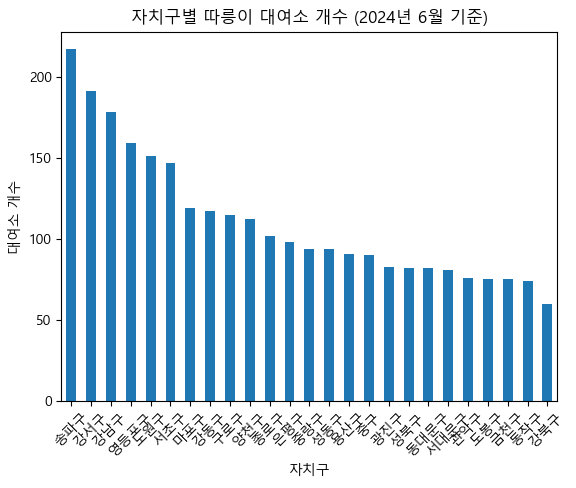

In [41]:
plt.figure(figsize=(12,6))

stations_per_gu.sort_values("대여소_개수", ascending=False).plot(
    x="자치구", y="대여소_개수", kind="bar", legend=False
)
plt.title("자치구별 따릉이 대여소 개수 (2024년 6월 기준)")
plt.ylabel("대여소 개수")
plt.xlabel("자치구")
plt.xticks(rotation=45)

plt.show()

In [43]:
# 지도 초기
m = folium.Map(
    location=[37.5665, 126.9780],
    zoom_start=11,
    tiles="cartodbpositron",
    min_zoom=10,
    max_zoom=11
)

# Choropleth 추가
folium.Choropleth(
    geo_data=seoul_geo,
    data=stations_per_gu,
    columns=["자치구", "대여소_개수"],
    key_on="feature.properties.name", 
    fill_color="YlGnBu",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="자치구별 따릉이 대여소 수 (2024.06)"
).add_to(m)

# 화면 맞추기
bounds = folium.GeoJson(seoul_geo).get_bounds()
m.fit_bounds(bounds)

m

## 3. 자치구별 6월 이용량 집계

In [46]:
usage = pd.read_csv("./data/working/tpss_bcycl_od_statnhm_202406_통합_w_자치구.csv")

In [47]:
usage.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수,전체_이용_분,전체_이용_거리
0,20240601,출발시간,0,ST-1002,목1동_004_1,양천구,ST-1017,목5동_059_1,양천구,1,8.0,870.0
1,20240601,출발시간,0,ST-1015,목5동_001_1,양천구,ST-997,목4동_021_1,양천구,1,10.0,1552.0
2,20240601,출발시간,0,ST-1036,역촌동_001_1,은평구,ST-1035,불광2동_021_1,은평구,1,42.0,4980.0
3,20240601,출발시간,0,ST-1045,성내2동_007_1,강동구,ST-1580,오륜동_001_3,송파구,1,8.0,1923.0
4,20240601,출발시간,0,ST-1047,성내1동_023_1,강동구,ST-488,암사1동_044_1,강동구,1,18.0,3530.0


In [48]:
usage.shape

(8831528, 12)

In [49]:
usage.dtypes

기준_날짜           int64
집계_기준          object
기준_시간대          int64
시작_대여소_ID      object
시작_대여소명        object
시작_대여소_자치구     object
종료_대여소_ID      object
종료_대여소명        object
종료_대여소_자치구     object
전체_건수           int64
전체_이용_분       float64
전체_이용_거리      float64
dtype: object

In [50]:
usage["기준_시간대"].unique()

array([   0,    5,   10,   15,   20,   25,   30,   35,   40,   45,   50,
         55,  100,  105,  110,  115,  120,  125,  130,  135,  140,  145,
        150,  155,  200,  205,  210,  215,  220,  225,  230,  235,  240,
        245,  250,  255,  300,  305,  310,  315,  320,  325,  330,  335,
        340,  345,  350,  355,  400,  405,  410,  415,  420,  425,  430,
        435,  440,  445,  450,  455,  500,  505,  510,  515,  520,  525,
        530,  535,  540,  545,  550,  555,  600,  605,  610,  615,  620,
        625,  630,  635,  640,  645,  650,  655,  700,  705,  710,  715,
        720,  725,  730,  735,  740,  745,  750,  755,  800,  805,  810,
        815,  820,  825,  830,  835,  840,  845,  850,  855,  900,  905,
        910,  915,  920,  925,  930,  935,  940,  945,  950,  955, 1000,
       1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055,
       1100, 1105, 1110, 1115, 1120, 1125, 1130, 1135, 1140, 1145, 1150,
       1155, 1200, 1205, 1210, 1215, 1220, 1225, 12

In [51]:
usage["기준_시간대"].nunique()

288

In [58]:
usage.isnull().sum()

기준_날짜              0
집계_기준              0
기준_시간대             0
시작_대여소_ID          0
시작_대여소명            0
시작_대여소_자치구       552
종료_대여소_ID          0
종료_대여소명        30932
종료_대여소_자치구     31304
전체_건수              0
전체_이용_분       193545
전체_이용_거리      193545
dtype: int64

- `전체_이용_분`, `전체_이용_거리` -> 분석에 쓰지 않으니 drop

In [61]:
# 원본(usage)은 그대로 둠
usage_cleaned = usage.copy()

In [63]:
# 불필요한 컬럼
usage_cleaned = usage_cleaned.drop(columns=["전체_이용_분", "전체_이용_거리"], errors="ignore")

In [65]:
usage_cleaned.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수
0,20240601,출발시간,0,ST-1002,목1동_004_1,양천구,ST-1017,목5동_059_1,양천구,1
1,20240601,출발시간,0,ST-1015,목5동_001_1,양천구,ST-997,목4동_021_1,양천구,1
2,20240601,출발시간,0,ST-1036,역촌동_001_1,은평구,ST-1035,불광2동_021_1,은평구,1
3,20240601,출발시간,0,ST-1045,성내2동_007_1,강동구,ST-1580,오륜동_001_3,송파구,1
4,20240601,출발시간,0,ST-1047,성내1동_023_1,강동구,ST-488,암사1동_044_1,강동구,1


In [67]:
usage_cleaned.shape

(8831528, 10)

- `시작_대여소_자치구`, `종료_대여소_자치구` -> 둘 중 하나라도 NaN이면 행 제거
    - 집계기준(`출발시간`, `도착시간`)이 매칭되어야 "대여량+반납량"을 합산해서 이용량을 계산할 수 있는데, 자치구가 하나라도 빠지면 매핑이 불가능하기 때문

In [70]:
# 시작/종료 자치구 중 하나라도 결측이면 제거
usage_cleaned = usage_cleaned.dropna(subset=["시작_대여소_자치구", "종료_대여소_자치구"])

In [71]:
usage_cleaned.shape

(8799690, 10)

In [74]:
usage_cleaned["기준_시간대"].nunique()

288

In [76]:
print(len(usage_cleaned[usage_cleaned["집계_기준"] == "출발시간"]))
print(len(usage_cleaned[usage_cleaned["집계_기준"] == "도착시간"]))

4412120
4387570


In [78]:
usage_cleaned.isnull().sum()

기준_날짜         0
집계_기준         0
기준_시간대        0
시작_대여소_ID     0
시작_대여소명       0
시작_대여소_자치구    0
종료_대여소_ID     0
종료_대여소명       0
종료_대여소_자치구    0
전체_건수         0
dtype: int64

In [80]:
usage_cleaned.dtypes

기준_날짜          int64
집계_기준         object
기준_시간대         int64
시작_대여소_ID     object
시작_대여소명       object
시작_대여소_자치구    object
종료_대여소_ID     object
종료_대여소명       object
종료_대여소_자치구    object
전체_건수          int64
dtype: object

- 이상치 확인
    - `"기준_날짜"` : yyyymmdd 형식
    - `"전체_건수"` : 음수 값 X, 통상적으로 너무 큰 값
    - `"집계_기준"` : 출발시간 or 도착시간
    - `"시작_대여소_자치구"`, `"종료_대여소_자치구"` : 25개 자치구 외 값 확인

In [83]:
# yyyymmdd 형식
pd.to_datetime(usage_cleaned["기준_날짜"], format="%Y%m%d", errors="coerce").isnull().sum()

0

In [85]:
# 통상적으로 큰 값
usage_cleaned["전체_건수"].describe()

count    8.799690e+06
mean     1.066948e+00
std      2.855639e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.800000e+01
Name: 전체_건수, dtype: float64

In [87]:
# 음수 값 X
(usage_cleaned["전체_건수"] < 0).sum()

0

In [89]:
# 출발시간 or 도착시간
usage_cleaned["집계_기준"].value_counts()

집계_기준
출발시간    4412120
도착시간    4387570
Name: count, dtype: int64

In [91]:
# 시작_대여소_자치구 : 25개 자치구 외 값 확인
set(usage_cleaned["시작_대여소_자치구"].dropna().unique())

{'강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구'}

In [93]:
len(usage_cleaned["시작_대여소_자치구"].dropna().unique())

25

In [94]:
# 종료_대여소_자치구 : 25개 자치구 외 값 확인
set(usage_cleaned["종료_대여소_자치구"].dropna().unique())

{'강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구'}

In [96]:
len(usage_cleaned["종료_대여소_자치구"].dropna().unique())

25

- 1시간 단위 `"기준_시간"` 컬럼 추가

In [100]:
usage_cleaned["기준_시간"] = usage_cleaned["기준_시간대"] // 100

In [102]:
usage_cleaned.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수,기준_시간
0,20240601,출발시간,0,ST-1002,목1동_004_1,양천구,ST-1017,목5동_059_1,양천구,1,0
1,20240601,출발시간,0,ST-1015,목5동_001_1,양천구,ST-997,목4동_021_1,양천구,1,0
2,20240601,출발시간,0,ST-1036,역촌동_001_1,은평구,ST-1035,불광2동_021_1,은평구,1,0
3,20240601,출발시간,0,ST-1045,성내2동_007_1,강동구,ST-1580,오륜동_001_3,송파구,1,0
4,20240601,출발시간,0,ST-1047,성내1동_023_1,강동구,ST-488,암사1동_044_1,강동구,1,0


In [104]:
usage_cleaned.shape

(8799690, 11)

In [106]:
usage_cleaned["기준_시간"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [108]:
usage_cleaned["기준_시간"].nunique()

24

- "활성", "중간", "비활성" `"시간_구분"` 컬럼 추가

In [111]:
# 활성, 중간, 비활성 리스트
active_hours = [8, 16, 17, 18, 19, 20]
mid_hours = [0, 6, 7, 9, 10, 11, 12, 13, 14, 15, 21, 22]
inactive_hours = [1, 2, 3, 4, 5, 23]

# "시간_구분" 생성 함수
def get_time_category(hour):
    if hour in active_hours:
        return "활성"
    elif hour in mid_hours:
        return "중간"
    elif hour in inactive_hours:
        return "비활성"
    else:
        return "기타"

# "시간_구분" 컬럼 추가 
usage_cleaned["시간_구분"] = usage_cleaned["기준_시간"].apply(get_time_category)

In [112]:
usage_cleaned.shape

(8799690, 12)

In [113]:
usage_cleaned.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수,기준_시간,시간_구분
0,20240601,출발시간,0,ST-1002,목1동_004_1,양천구,ST-1017,목5동_059_1,양천구,1,0,중간
1,20240601,출발시간,0,ST-1015,목5동_001_1,양천구,ST-997,목4동_021_1,양천구,1,0,중간
2,20240601,출발시간,0,ST-1036,역촌동_001_1,은평구,ST-1035,불광2동_021_1,은평구,1,0,중간
3,20240601,출발시간,0,ST-1045,성내2동_007_1,강동구,ST-1580,오륜동_001_3,송파구,1,0,중간
4,20240601,출발시간,0,ST-1047,성내1동_023_1,강동구,ST-488,암사1동_044_1,강동구,1,0,중간


In [117]:
usage_cleaned.tail()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수,기준_시간,시간_구분
8831523,20240630,도착시간,2355,ST-950,조원동_032_1,관악구,ST-709,미성동_014_1,관악구,1,23,비활성
8831524,20240630,도착시간,2355,ST-976,신림동_018_1,관악구,ST-2428,낙성대동_029_1,관악구,1,23,비활성
8831525,20240630,도착시간,2355,ST-988,자양3동_029_1,광진구,ST-114,군자동_020_1,광진구,1,23,비활성
8831526,20240630,도착시간,2355,ST-994,목1동_003_4,양천구,ST-2774,목5동_049_1,양천구,1,23,비활성
8831527,20240630,도착시간,2355,ST-997,목4동_021_1,양천구,ST-1546,조원동_004_1,관악구,1,23,비활성


In [119]:
usage_cleaned.shape

(8799690, 12)

In [121]:
usage_cleaned["기준_시간"].nunique()

24

In [123]:
subset = usage_cleaned[(usage_cleaned["기준_시간"] == 1) & (usage_cleaned["집계_기준"] == "출발시간")]

In [125]:
subset.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수,기준_시간,시간_구분
6423,20240601,출발시간,100,ST-1015,목5동_001_1,양천구,ST-997,목4동_021_1,양천구,1,1,비활성
6424,20240601,출발시간,100,ST-1064,발산1동_060_1,강서구,ST-2419,발산1동_066_1,강서구,1,1,비활성
6425,20240601,출발시간,100,ST-1065,가양1동_040_1,강서구,ST-1067,가양2동_001_1,강서구,1,1,비활성
6426,20240601,출발시간,100,ST-1065,가양1동_040_1,강서구,ST-1510,등촌1동_001_1,강서구,1,1,비활성
6427,20240601,출발시간,100,ST-1065,가양1동_040_1,강서구,ST-2550,가양3동_015_2,강서구,1,1,비활성


In [127]:
subset["전체_건수"].unique()

array([1, 4, 2, 3, 5, 6], dtype=int64)

In [129]:
subset["전체_건수"].value_counts()

전체_건수
1    62198
2     2687
3      196
4       35
5       11
6        1
Name: count, dtype: int64

In [131]:
subset["전체_건수"].sum()

68361

In [133]:
62198 + (2687 * 2) + (196 * 3) + (35 * 4) + (11 * 5) + (1 * 6)

68361

- `"집계_기준"`에 따라 분리 (출발시간/도착시간)

In [136]:
rental_data = usage_cleaned[usage_cleaned["집계_기준"] == "출발시간"].copy()
return_data = usage_cleaned[usage_cleaned["집계_기준"] == "도착시간"].copy()

In [137]:
print("대여 데이터 행 수:", len(rental_data))
print("반납 데이터 행 수:", len(return_data))

대여 데이터 행 수: 4412120
반납 데이터 행 수: 4387570


In [140]:
# 대여량 (자치구, 시간대별로 집계)
rental_sum = (
    usage_cleaned.groupby(['시작_대여소_자치구','시간_구분'])['전체_건수']
    .sum()
    .reset_index()
    .rename(columns={'시작_대여소_자치구':'자치구','전체_건수':'대여_건수'})
)

In [141]:
# 반납량 (자치구, 시간대별로 집계)
return_sum = (
    usage_cleaned.groupby(['종료_대여소_자치구','시간_구분'])['전체_건수']
    .sum()
    .reset_index()
    .rename(columns={'종료_대여소_자치구':'자치구','전체_건수':'반납_건수'})
)

In [142]:
rental_sum.head()

,자치구,시간_구분,대여_건수
0,강남구,비활성,24654
1,강남구,중간,144556
2,강남구,활성,152997
3,강동구,비활성,33550
4,강동구,중간,205115


In [146]:
return_sum.head()

,자치구,시간_구분,반납_건수
0,강남구,비활성,23648
1,강남구,중간,145245
2,강남구,활성,139834
3,강동구,비활성,34465
4,강동구,중간,203305


In [148]:
# return_sum + rental_sum
merged_df = pd.merge(rental_sum, return_sum, on=["자치구", "시간_구분"], how="outer").fillna(0)
merged_df

,자치구,시간_구분,대여_건수,반납_건수
0,강남구,비활성,24654,23648
1,강남구,중간,144556,145245
2,강남구,활성,152997,139834
3,강동구,비활성,33550,34465
4,강동구,중간,205115,203305
...,...,...,...,...
70,중구,중간,93093,96362
71,중구,활성,94846,83600
72,중랑구,비활성,27222,28026
73,중랑구,중간,127871,125921


# **컬럼1. `|(대여) - (반납)|` 불균형**

In [151]:
merged_df

,자치구,시간_구분,대여_건수,반납_건수
0,강남구,비활성,24654,23648
1,강남구,중간,144556,145245
2,강남구,활성,152997,139834
3,강동구,비활성,33550,34465
4,강동구,중간,205115,203305
...,...,...,...,...
70,중구,중간,93093,96362
71,중구,활성,94846,83600
72,중랑구,비활성,27222,28026
73,중랑구,중간,127871,125921


In [153]:
temp_df = merged_df.copy()
temp_df["|대여-반납|"] = (temp_df["대여_건수"] - temp_df["반납_건수"]).abs()

In [155]:
temp_df.head()

,자치구,시간_구분,대여_건수,반납_건수,|대여-반납|
0,강남구,비활성,24654,23648,1006
1,강남구,중간,144556,145245,689
2,강남구,활성,152997,139834,13163
3,강동구,비활성,33550,34465,915
4,강동구,중간,205115,203305,1810


In [157]:
temp_df.shape

(75, 5)

- 시간대별로 따로: 자치구별 `|대여-반납|` 막대그래프

In [160]:
def plot_abs_by_cate(df, cate):
    sub = df[df["시간_구분"] == cate].copy()
    sub = sub.sort_values("|대여-반납|", ascending=False)

    plt.figure(figsize=(12, 6))
    plt.bar(sub["자치구"], sub["|대여-반납|"])
    plt.title(f"{cate} 시간대 |대여-반납| (내림차순)")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("|대여-반납|")
    plt.tight_layout()
    plt.show()

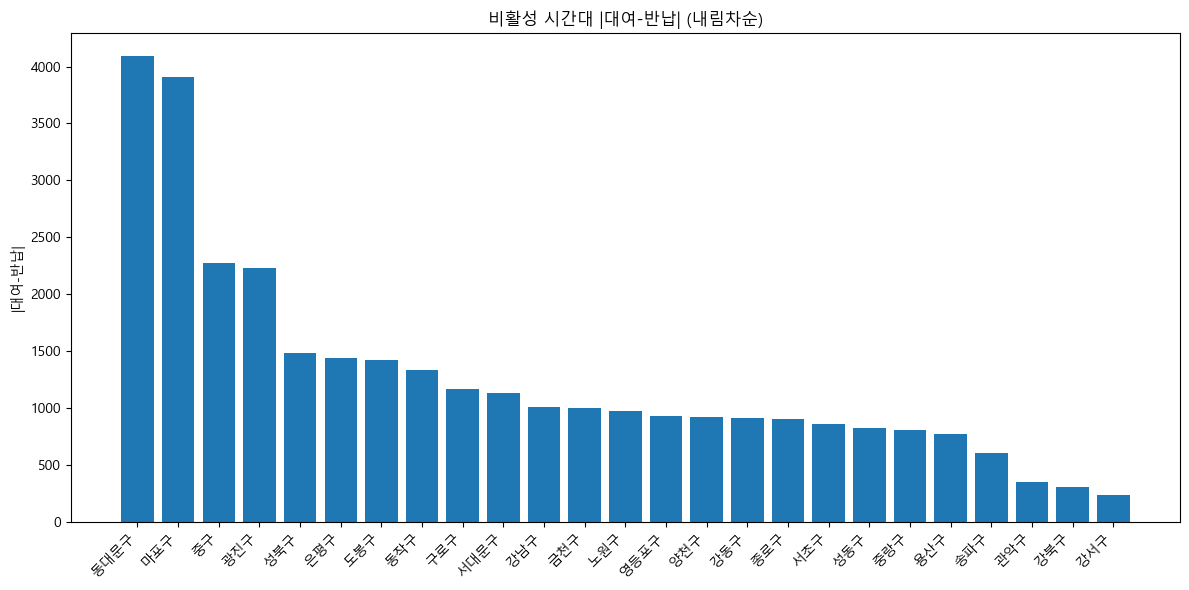

In [162]:
plot_abs_by_cate(temp_df, "비활성")

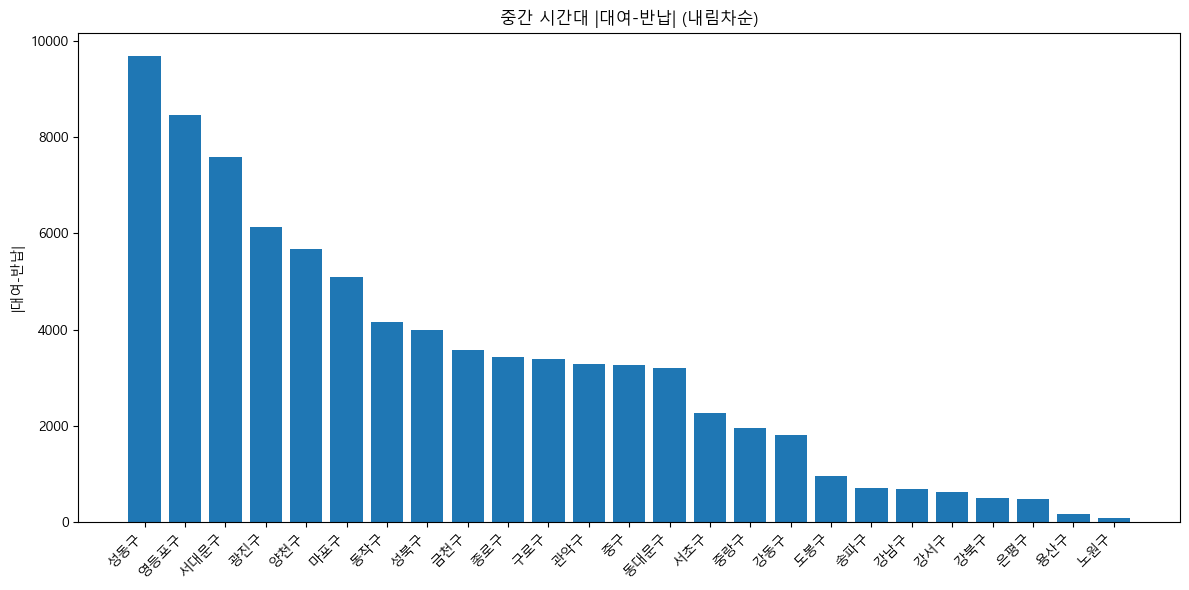

In [164]:
plot_abs_by_cate(temp_df, "중간")

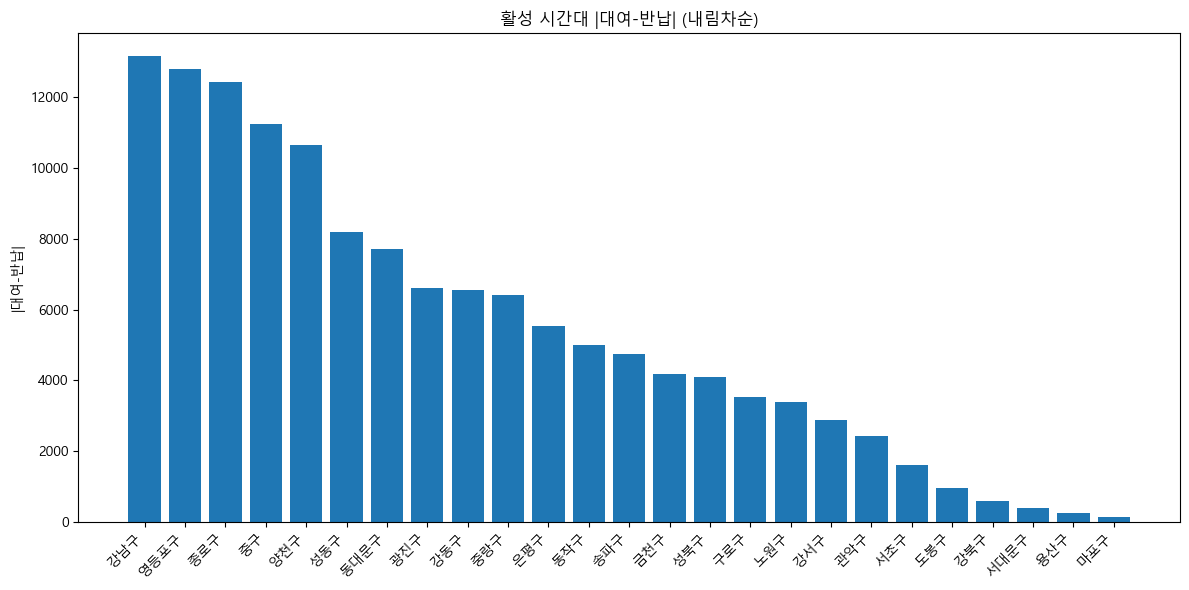

In [166]:
plot_abs_by_cate(temp_df, "활성")

- csv 파일로 추출

In [169]:
for cate in ["비활성", "중간", "활성"]:
    sub = temp_df[temp_df["시간_구분"] == cate].reset_index(drop=True)

    # 확인 출력
    print(f"\n>> {cate}시간")
    print(sub.head())


>> 비활성시간
   자치구 시간_구분  대여_건수  반납_건수  |대여-반납|
0  강남구   비활성  24654  23648     1006
1  강동구   비활성  33550  34465      915
2  강북구   비활성  15216  14907      309
3  강서구   비활성  68793  69028      235
4  관악구   비활성  24605  24254      351

>> 중간시간
   자치구 시간_구분   대여_건수   반납_건수  |대여-반납|
0  강남구    중간  144556  145245      689
1  강동구    중간  205115  203305     1810
2  강북구    중간   58020   57519      501
3  강서구    중간  517461  516849      612
4  관악구    중간   94705   91414     3291

>> 활성시간
   자치구 시간_구분   대여_건수   반납_건수  |대여-반납|
0  강남구    활성  152997  139834    13163
1  강동구    활성  182775  189338     6563
2  강북구    활성   51588   51014      574
3  강서구    활성  523925  526801     2876
4  관악구    활성   82468   84885     2417


In [171]:
for cate in ["비활성", "중간", "활성"]:
    sub = temp_df[temp_df["시간_구분"] == cate].reset_index(drop=True)

    # CSV 파일명
    filename = os.path.join(COLUMNS_DIR, f"컬럼1_{cate}시간.csv")

    # 저장
    sub.to_csv(filename, index=False, encoding="utf-8-sig")

    # 확인 출력
    print(f"저장 완료: {filename}")

저장 완료: ./data/columns/컬럼1_비활성시간.csv
저장 완료: ./data/columns/컬럼1_중간시간.csv
저장 완료: ./data/columns/컬럼1_활성시간.csv


# **컬럼5. 회전율**

- 회전율 = (자치구 별 대여 + 반납 수) / 대여소 개수

In [174]:
stations_per_gu

,자치구,대여소_개수
0,강남구,178
1,강동구,117
2,강북구,60
3,강서구,191
4,관악구,76
5,광진구,83
6,구로구,115
7,금천구,75
8,노원구,151
9,도봉구,75


In [176]:
stations_per_gu["대여소_개수"].sum()

2763

In [178]:
merged_df

,자치구,시간_구분,대여_건수,반납_건수
0,강남구,비활성,24654,23648
1,강남구,중간,144556,145245
2,강남구,활성,152997,139834
3,강동구,비활성,33550,34465
4,강동구,중간,205115,203305
...,...,...,...,...
70,중구,중간,93093,96362
71,중구,활성,94846,83600
72,중랑구,비활성,27222,28026
73,중랑구,중간,127871,125921


In [180]:
temp_df = merged_df.copy()
temp_df["대여_반납_합계"] = temp_df["대여_건수"] + temp_df["반납_건수"]

In [182]:
temp_df

,자치구,시간_구분,대여_건수,반납_건수,대여_반납_합계
0,강남구,비활성,24654,23648,48302
1,강남구,중간,144556,145245,289801
2,강남구,활성,152997,139834,292831
3,강동구,비활성,33550,34465,68015
4,강동구,중간,205115,203305,408420
...,...,...,...,...,...
70,중구,중간,93093,96362,189455
71,중구,활성,94846,83600,178446
72,중랑구,비활성,27222,28026,55248
73,중랑구,중간,127871,125921,253792


In [184]:
temp_df = pd.merge(temp_df, stations_per_gu, on="자치구", how="left")
temp_df

,자치구,시간_구분,대여_건수,반납_건수,대여_반납_합계,대여소_개수
0,강남구,비활성,24654,23648,48302,178
1,강남구,중간,144556,145245,289801,178
2,강남구,활성,152997,139834,292831,178
3,강동구,비활성,33550,34465,68015,117
4,강동구,중간,205115,203305,408420,117
...,...,...,...,...,...,...
70,중구,중간,93093,96362,189455,90
71,중구,활성,94846,83600,178446,90
72,중랑구,비활성,27222,28026,55248,94
73,중랑구,중간,127871,125921,253792,94


In [186]:
temp_df["회전율"] = temp_df["대여_반납_합계"] / temp_df["대여소_개수"]
temp_df

,자치구,시간_구분,대여_건수,반납_건수,대여_반납_합계,대여소_개수,회전율
0,강남구,비활성,24654,23648,48302,178,271.359551
1,강남구,중간,144556,145245,289801,178,1628.095506
2,강남구,활성,152997,139834,292831,178,1645.117978
3,강동구,비활성,33550,34465,68015,117,581.324786
4,강동구,중간,205115,203305,408420,117,3490.769231
...,...,...,...,...,...,...,...
70,중구,중간,93093,96362,189455,90,2105.055556
71,중구,활성,94846,83600,178446,90,1982.733333
72,중랑구,비활성,27222,28026,55248,94,587.744681
73,중랑구,중간,127871,125921,253792,94,2699.914894


- 자치구별 시간_구분에 따른 회전율

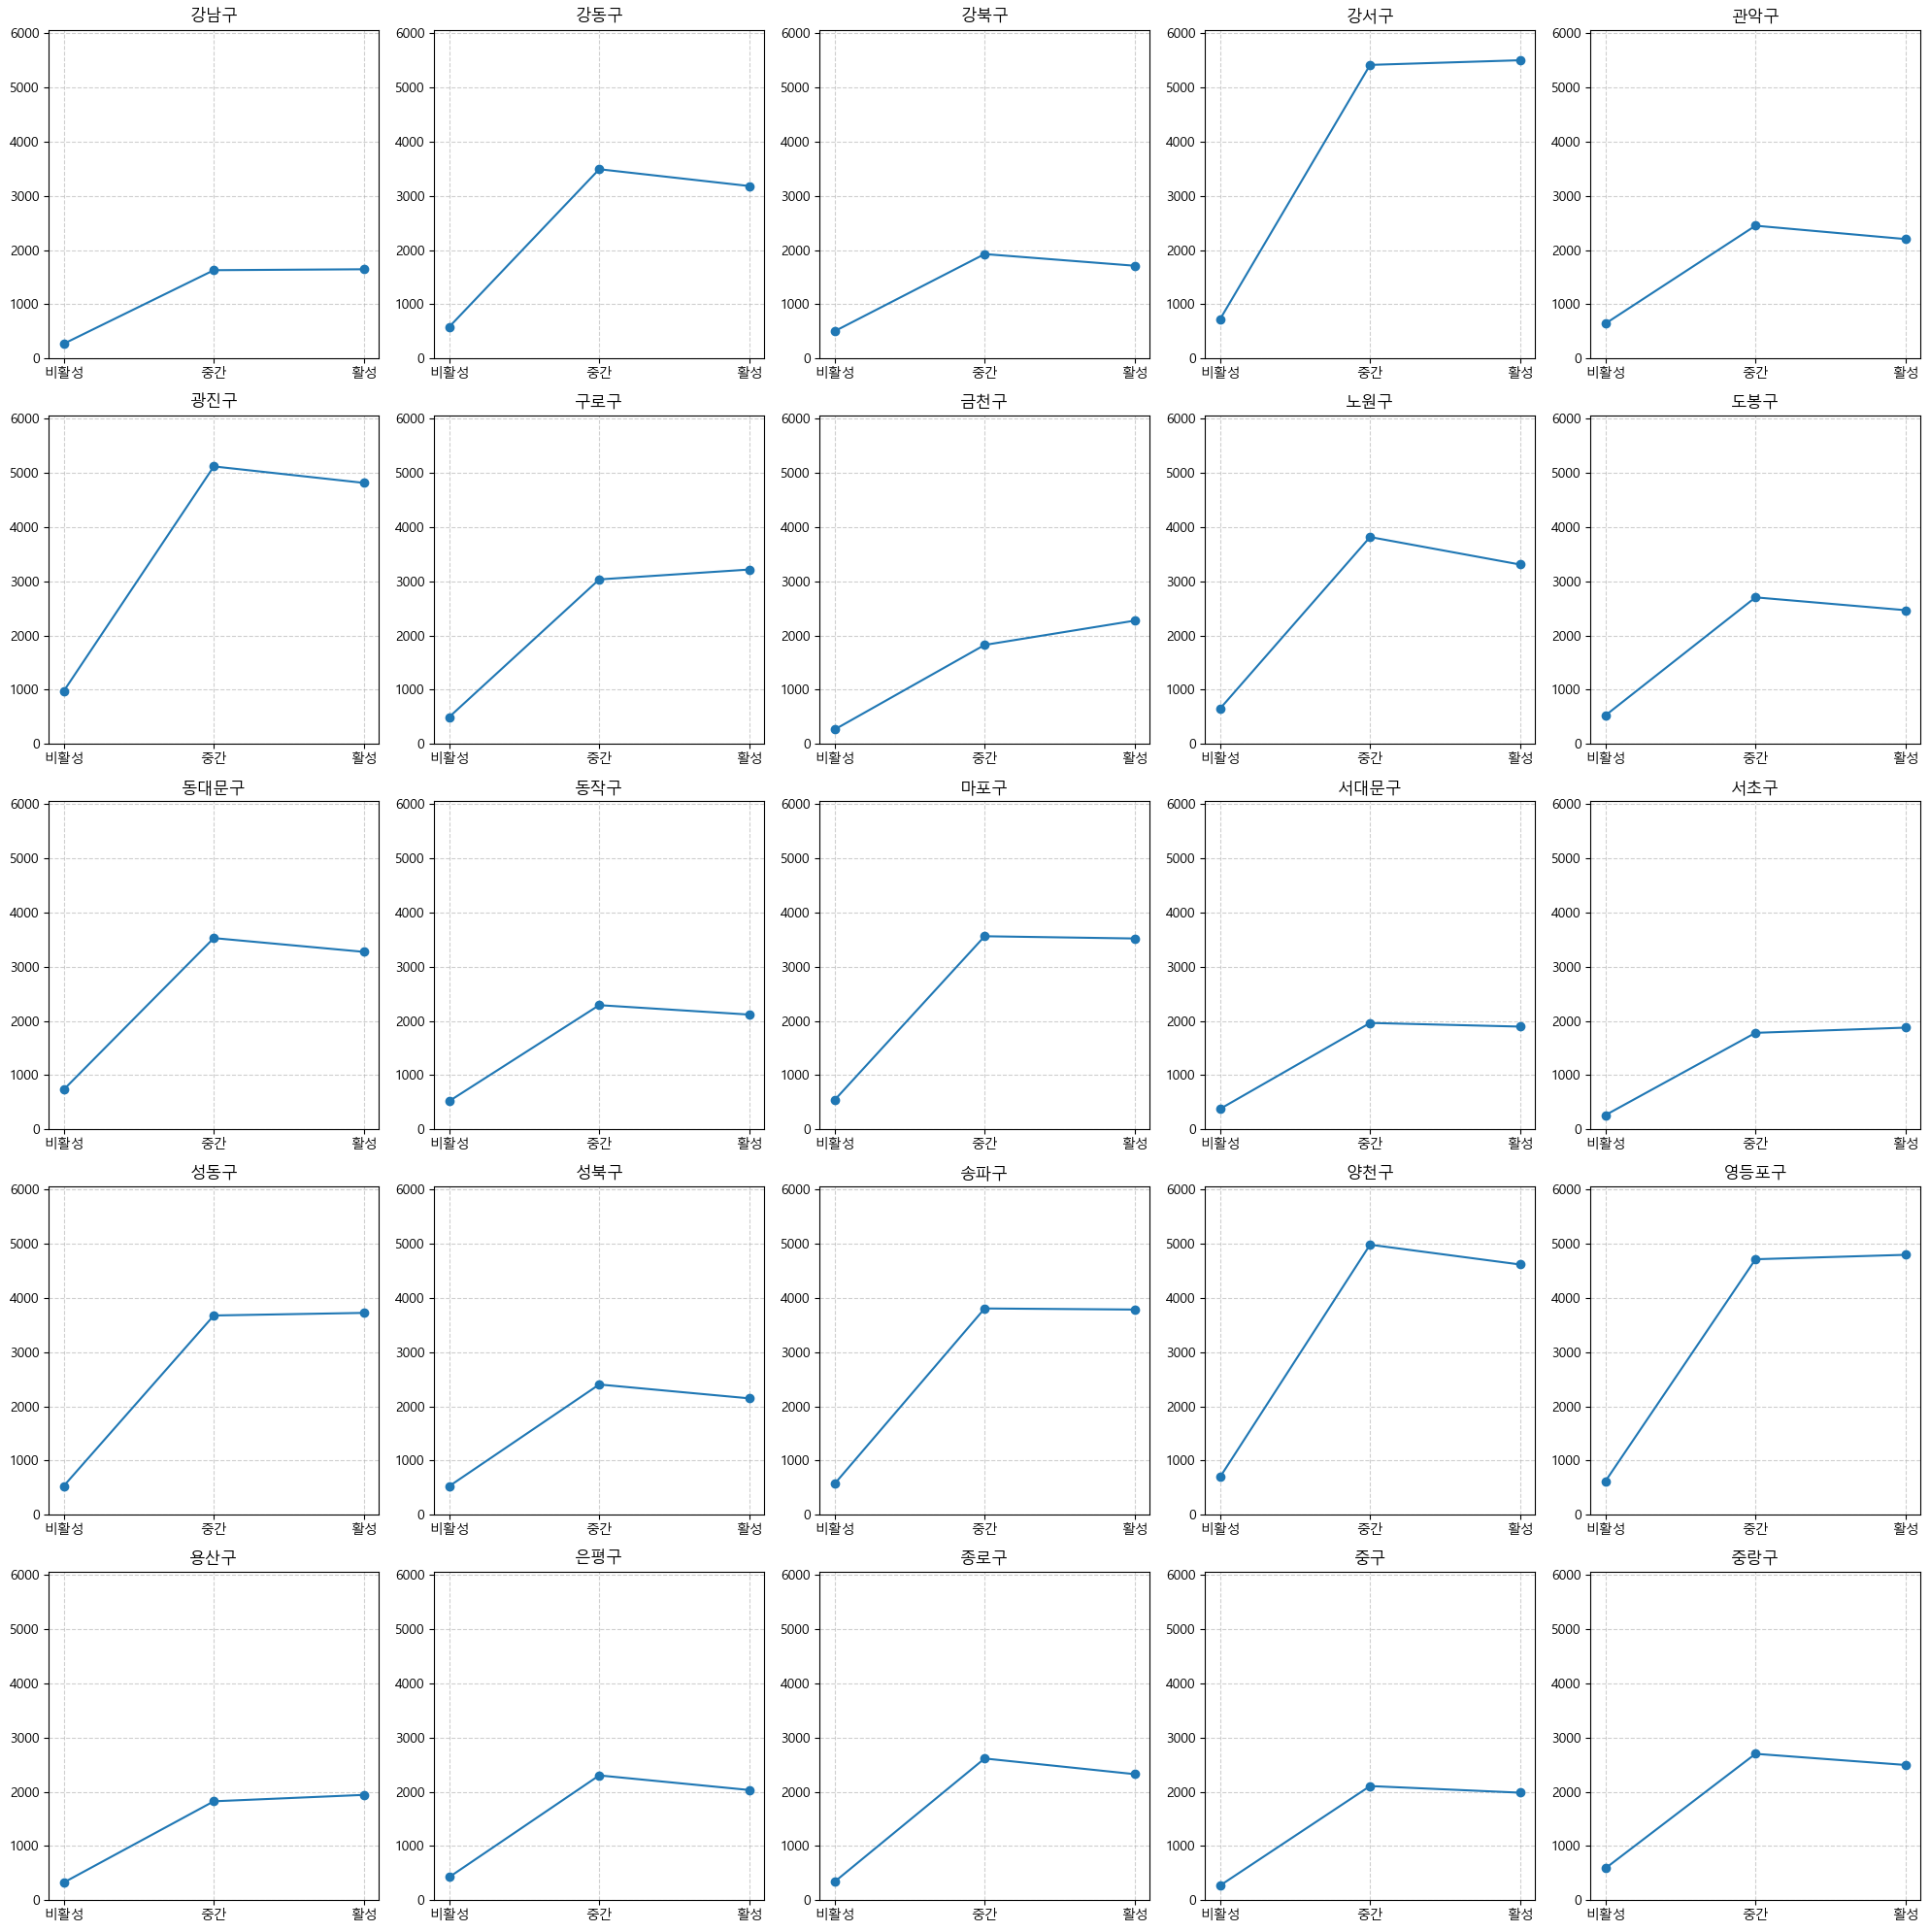

In [189]:
gu_list = temp_df["자치구"].unique()

fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for i, gu in enumerate(gu_list):
    ax = axes[i]
    subset = temp_df[temp_df["자치구"] == gu]
    ax.plot(subset["시간_구분"], subset["회전율"], marker="o")
    ax.set_title(f"{gu}", fontsize=12)
    ax.set_ylim(0, temp_df["회전율"].max() * 1.1)
    ax.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

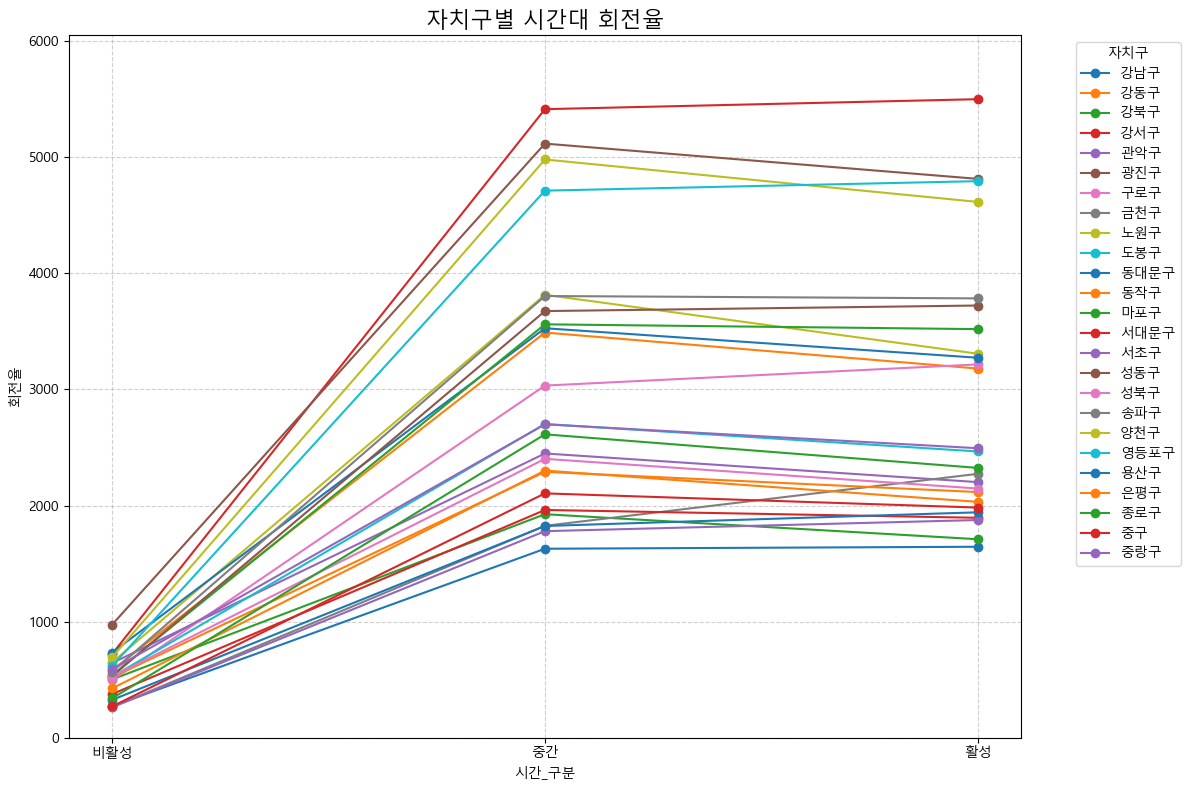

In [190]:
plt.figure(figsize=(12, 8))

# 자치구별
for gu in temp_df["자치구"].unique():
    subset = temp_df[temp_df["자치구"] == gu]
    plt.plot(subset["시간_구분"], subset["회전율"], marker="o", label=gu)

plt.title("자치구별 시간대 회전율", fontsize=16)
plt.xlabel("시간_구분")
plt.ylabel("회전율")
plt.ylim(0, temp_df["회전율"].max() * 1.1)
plt.grid(True, linestyle="--", alpha=0.6)

# 범례
plt.legend(title="자치구", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

- Box Plot

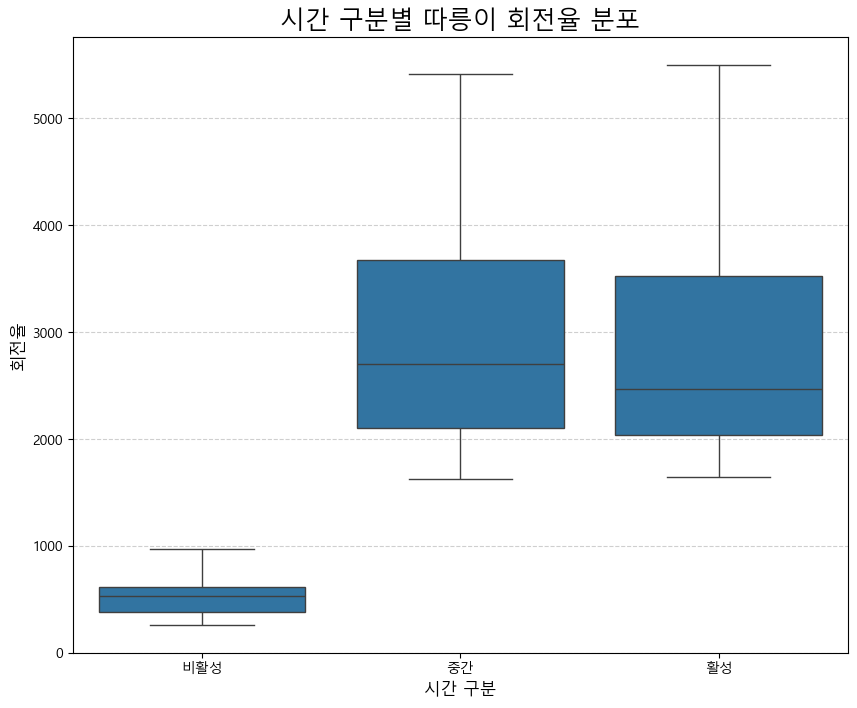

In [194]:
plt.figure(figsize=(10, 8))

sns.boxplot(x="시간_구분", y="회전율", data=temp_df, order=["비활성", "중간", "활성"])
plt.title("시간 구분별 따릉이 회전율 분포", fontsize=18)
plt.xlabel("시간 구분", fontsize=12)
plt.ylabel("회전율", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()

- 지도 생성

In [197]:
time_categories = ["비활성", "중간", "활성"]

for category in time_categories:
    map_data = temp_df[temp_df["시간_구분"] == category][["자치구", "회전율"]]

    # 지도 생성
    m = folium.Map(
        location=[37.5665, 126.9780],
        zoom_start=11,
        tiles="cartodbpositron",
        min_zoom=10,
        max_zoom=11,
    )

    # Choropleth 시각화
    folium.Choropleth(
        geo_data=seoul_geo,
        data=map_data,
        columns=["자치구", "회전율"],
        key_on="properties.name",
        fill_color="YlGnBu",
        fill_opacity=0.7,
        line_opacity=0.5,
        legend_name=f"자치구별 따릉이 회전율 ({category} 시간대)",
        highlight=True
    ).add_to(m)
    
    # 툴팁에 회전율 추가
    for feature in seoul_geo["features"]:
        gu_name = feature["properties"]["name"]
        rate = map_data[map_data["자치구"] == gu_name]["회전율"].iloc[0] if not map_data[map_data["자치구"] == gu_name].empty else "N/A"
        
        folium.features.GeoJson(
            feature,
            tooltip=folium.Tooltip(f"{gu_name}: {rate:.2f}"),
            style_function=lambda x: {"fillColor": "#ffffff", "color":"#000000", "fillOpacity":0.1, "weight":0.1},
            highlight_function=lambda x: {"fillColor": "#000000", "color":"#000000", "fillOpacity":0.50, "weight":0.1}
        ).add_to(m)
    
    # 지도 출력
    print(f">>>{category}")
    display(m)

>>>비활성


>>>중간


>>>활성


- csv 파일 추출

In [200]:
temp_df

,자치구,시간_구분,대여_건수,반납_건수,대여_반납_합계,대여소_개수,회전율
0,강남구,비활성,24654,23648,48302,178,271.359551
1,강남구,중간,144556,145245,289801,178,1628.095506
2,강남구,활성,152997,139834,292831,178,1645.117978
3,강동구,비활성,33550,34465,68015,117,581.324786
4,강동구,중간,205115,203305,408420,117,3490.769231
...,...,...,...,...,...,...,...
70,중구,중간,93093,96362,189455,90,2105.055556
71,중구,활성,94846,83600,178446,90,1982.733333
72,중랑구,비활성,27222,28026,55248,94,587.744681
73,중랑구,중간,127871,125921,253792,94,2699.914894


In [202]:
for cate in ["비활성", "중간", "활성"]:
    sub = temp_df.loc[temp_df["시간_구분"] == cate, ["자치구", "시간_구분", "회전율"]].reset_index(drop=True)

    # 확인 출력
    print(f"\n>> {cate}시간")
    print(sub.head())


>> 비활성시간
   자치구 시간_구분         회전율
0  강남구   비활성  271.359551
1  강동구   비활성  581.324786
2  강북구   비활성  502.050000
3  강서구   비활성  721.575916
4  관악구   비활성  642.881579

>> 중간시간
   자치구 시간_구분          회전율
0  강남구    중간  1628.095506
1  강동구    중간  3490.769231
2  강북구    중간  1925.650000
3  강서구    중간  5415.235602
4  관악구    중간  2448.934211

>> 활성시간
   자치구 시간_구분          회전율
0  강남구    활성  1645.117978
1  강동구    활성  3180.452991
2  강북구    활성  1710.033333
3  강서구    활성  5501.183246
4  관악구    활성  2202.013158


In [204]:
for cate in ["비활성", "중간", "활성"]:
    sub = temp_df.loc[temp_df["시간_구분"] == cate, ["자치구", "시간_구분", "회전율"]].reset_index(drop=True)

    # 파일명
    filename = os.path.join(COLUMNS_DIR, f"컬럼5_{cate}시간.csv")

    # 저장
    sub.to_csv(filename, index=False, encoding="utf-8-sig")

    # 확인 출력
    print(f"저장 완료: {filename}")

저장 완료: ./data/columns/컬럼5_비활성시간.csv
저장 완료: ./data/columns/컬럼5_중간시간.csv
저장 완료: ./data/columns/컬럼5_활성시간.csv


# **컬럼6. 시간대 별(00~23시) 이용량 편차**

- 이용량 편차 = (최대) - (최소)
- 시간대별로 전체_건수 합산

In [207]:
usage_cleaned.head()

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,시작_대여소_자치구,종료_대여소_ID,종료_대여소명,종료_대여소_자치구,전체_건수,기준_시간,시간_구분
0,20240601,출발시간,0,ST-1002,목1동_004_1,양천구,ST-1017,목5동_059_1,양천구,1,0,중간
1,20240601,출발시간,0,ST-1015,목5동_001_1,양천구,ST-997,목4동_021_1,양천구,1,0,중간
2,20240601,출발시간,0,ST-1036,역촌동_001_1,은평구,ST-1035,불광2동_021_1,은평구,1,0,중간
3,20240601,출발시간,0,ST-1045,성내2동_007_1,강동구,ST-1580,오륜동_001_3,송파구,1,0,중간
4,20240601,출발시간,0,ST-1047,성내1동_023_1,강동구,ST-488,암사1동_044_1,강동구,1,0,중간


In [209]:
# 출발/도착 분리
rental_data = usage_cleaned[usage_cleaned["집계_기준"] == "출발시간"].copy()
return_data = usage_cleaned[usage_cleaned["집계_기준"] == "도착시간"].copy()

In [210]:
# 자치구 × 시간대별 대여/반납 합계
rental_per_hour = (
    rental_data.groupby(["시작_대여소_자치구", "기준_시간"])["전체_건수"]
    .sum().reset_index()
    .rename(columns={"시작_대여소_자치구":"자치구", "전체_건수":"대여_건수"})
)

return_per_hour = (
    return_data.groupby(["종료_대여소_자치구", "기준_시간"])["전체_건수"]
    .sum().reset_index()
    .rename(columns={"종료_대여소_자치구":"자치구", "전체_건수":"반납_건수"})
)

In [211]:
# 총 이용량 (대여+반납)
per_hour = (
    rental_per_hour
    .merge(return_per_hour, on=["자치구","기준_시간"], how="outer")
    .fillna(0)
)

per_hour["총_이용량"] = per_hour["대여_건수"] + per_hour["반납_건수"]
per_hour

,자치구,기준_시간,대여_건수,반납_건수,총_이용량
0,강남구,0,3357,2306,5663
1,강남구,1,2673,2653,5326
2,강남구,2,1806,1994,3800
3,강남구,3,1253,1371,2624
4,강남구,4,911,1024,1935
...,...,...,...,...,...
595,중랑구,19,10522,11633,22155
596,중랑구,20,9820,10590,20410
597,중랑구,21,9084,9854,18938
598,중랑구,22,7577,9526,17103


In [215]:
# 4) 강남구에서 최대/최소 이용량과 해당 시간 찾기
gangnam = per_hour[per_hour["자치구"] == "강남구"].copy()

max_row = gangnam.loc[gangnam["총_이용량"].idxmax()]
min_row = gangnam.loc[gangnam["총_이용량"].idxmin()]
max_row

자치구        강남구
기준_시간       18
대여_건수    19251
반납_건수    15758
총_이용량    35009
Name: 18, dtype: object

In [217]:
min_row

자치구       강남구
기준_시간       4
대여_건수     911
반납_건수    1024
총_이용량    1935
Name: 4, dtype: object

In [219]:
# 자치구별 총_이용량 최대 행 1개
max_row_per_gu = (
    per_hour.sort_values(["자치구", "총_이용량"], ascending=[True, False])
            .groupby("자치구", as_index=False)
            .head(1)
)

max_row_per_gu = (
    max_row_per_gu
    .rename(columns={"총_이용량": "최대이용량", "기준_시간": "최대이용량_시간"})
    [["자치구", "최대이용량", "최대이용량_시간"]]
)

max_row_per_gu

,자치구,최대이용량,최대이용량_시간
18,강남구,35009,18
42,강동구,40674,18
66,강북구,10667,18
90,강서구,117428,18
114,관악구,18205,18
138,광진구,43960,18
162,구로구,43786,18
186,금천구,20862,18
210,노원구,51828,18
234,도봉구,20121,18


In [221]:
max_row_per_gu["최대이용량_시간"].nunique()

1

In [223]:
# 자치구별 총_이용량 최소 행 1개
min_row_per_gu = (
    per_hour.sort_values(["자치구", "총_이용량"], ascending=[True, True])
            .groupby("자치구", as_index=False)
            .head(1)
)

min_row_per_gu = (
    min_row_per_gu
    .rename(columns={"총_이용량": "최소이용량", "기준_시간": "최소이용량_시간"})
    [["자치구", "최소이용량", "최소이용량_시간"]]
)

min_row_per_gu

,자치구,최소이용량,최소이용량_시간
4,강남구,1935,4
28,강동구,2346,4
52,강북구,1473,4
76,강서구,4750,4
100,관악구,2032,4
124,광진구,2672,4
148,구로구,2422,4
172,금천구,719,4
196,노원구,3439,4
220,도봉구,1593,4


In [225]:
min_row_per_gu["최소이용량_시간"].nunique()

1

In [227]:
# 통합 (max_row_per_gu + min_row_per_gu)
merged_table = (
    min_row_per_gu.merge(max_row_per_gu, on="자치구", how="outer")
          .loc[:, ["자치구", "최소이용량", "최소이용량_시간", "최대이용량", "최대이용량_시간"]]
)

merged_table["최대최소_편차"] = merged_table["최대이용량"] - merged_table["최소이용량"]

merged_table

,자치구,최소이용량,최소이용량_시간,최대이용량,최대이용량_시간,최대최소_편차
0,강남구,1935,4,35009,18,33074
1,강동구,2346,4,40674,18,38328
2,강북구,1473,4,10667,18,9194
3,강서구,4750,4,117428,18,112678
4,관악구,2032,4,18205,18,16173
5,광진구,2672,4,43960,18,41288
6,구로구,2422,4,43786,18,41364
7,금천구,719,4,20862,18,20143
8,노원구,3439,4,51828,18,48389
9,도봉구,1593,4,20121,18,18528


In [229]:
# 필요한 컬럼만 추출
export_df = merged_table[["자치구", "최대이용량", "최소이용량", "최대최소_편차"]].copy()

# 저장 파일명
filename = os.path.join(COLUMNS_DIR, "컬럼6.csv")

# CSV 저장
export_df.to_csv(filename, index=True, encoding="utf-8-sig")  # index=True → index 컬럼 포함

export_df.head()

,자치구,최대이용량,최소이용량,최대최소_편차
0,강남구,35009,1935,33074
1,강동구,40674,2346,38328
2,강북구,10667,1473,9194
3,강서구,117428,4750,112678
4,관악구,18205,2032,16173
